# Evaluating Neural Network Performance: Metrics and Visualizations

This notebook introduces essential quantitative measures to evaluate neural network learning performance and how they are implemented in some of the Utils functions. We'll further explore key metrics and visualization techniques that help us understand:

1. How efficiently a model learns
2. Whether it's overfitting or underfitting
3. How its internal representations capture the structure of the data
4. How it performs on individual classes and examples

These insights are crucial for diagnosing problems, tuning hyperparameters, and ultimately building better models.

## 1. Setup and Imports

Let's start by importing the necessary libraries and the custom functions we'll use throughout this notebook.


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Dict, List, Tuple, Optional, Union, Any

# Import our custom functions
from functions import train_model, evaluate_model, test_model, get_model_predictions
from plotting import (visualize_training_results, 
                      visualize_test_results, 
                      visualize_misclassified, 
                      visualize_patch_embeddings)

from little_helpers import set_seed
# set random seed for reproducibility
set_seed(42)

### 1.1 The Importance of Setting Random Seeds in Deep Learning

Random seeds control the initialization of random number generators, which affect many aspects of neural network training:

1. **Weight initialization**: Random initial weights can lead to different local minima
2. **Data shuffling**: Different batch orderings affect gradient updates
3. **Dropout patterns**: Randomized dropout masks change which neurons are active
4. **Data augmentation**: Random transformations create different training examples

#### Benefits of fixed seeds:

1. **Reproducibility**: Ensures experiments can be reproduced exactly
2. **Debugging**: Helps distinguish between bugs and random variation
3. **Fair Comparisons**: Allows different models/approaches to be compared under identical conditions
4. **Scientific Rigor**: Makes results replicable by other researchers

#### Why CUDA-specific seed setting is necessary:

Neural network training often uses GPU acceleration through CUDA. Setting CUDA-specific seeds is critical because:

1. **GPU Parallelism**: GPUs use parallel processing with their own random number generators
2. **CUDA-specific operations**: Some operations have GPU-specific implementations with different random behaviors
3. **Multi-GPU setups**: Each GPU needs its own seed for consistent behavior

Our `set_seed()` function addresses these issues by:

- Setting Python's `random` seed for general randomization -> `random.seed(42)`
- Setting NumPy's seed for array operations -> `np.random.seed(42)`
- Setting PyTorch's CPU seed with `torch.manual_seed(42)`
- Setting CUDA seeds with `torch.cuda.manual_seed(42)` for the current device
- Setting all CUDA device seeds with `torch.cuda.manual_seed_all(42)` for using multiple GPUs
- Making CUDNN deterministic with `torch.backends.cudnn.deterministic = True`

The last setting (`cudnn.deterministic`) is particularly important but comes with a performance cost. It forces cuDNN to use deterministic algorithms instead of selecting the fastest but potentially non-deterministic implementation. For detailed information look [here](https://pytorch.org/docs/stable/notes/randomness.html).

> **Note**: Setting `torch.backends.cudnn.deterministic = True` can significantly slow down training, especially for convolutional networks. This trade-off between reproducibility and performance is an important consideration in research vs. production environments.


# 2. Understanding Training and Validation Metrics

### 2.1 Loss Functions: The Optimization Target

The loss function is the core metric that guides neural network optimization. It quantifies how far the model's predictions are from the ground truth.

<div align="center">
    <img src="figures/losses.png" width="1000"/>
    <p><i>Figure 1: Different loss behaviors</i></p>
</div>

Let's examine why monitoring loss is crucial:

1. **Good Convergence**: Both training and validation loss decrease and converge to similar values. The gap between them remains small, indicating the model generalizes well.

2. **Overfitting**: Training loss continues to decrease, but validation loss starts increasing after a certain point. This indicates the model is memorizing the training data rather than learning generalizable patterns.

3. **Underfitting**: Both losses plateau at relatively high values. This suggests the model lacks capacity to capture the underlying patterns in the data.

### 2.2 Accuracy: The Interpretable Metric

While loss functions drive optimization, accuracy is often more interpretable:

<div align="center">
    <img src="figures/accuracy.png" width="1000"/>
    <p><i>Figure 2: Different accuracy behaviors</i></p>
</div>

### 2.3 Using the `visualize_training_results` Function

Our `visualize_training_results` function makes it easy to plot both loss and accuracy during training:

```python
# the history will be returned from train_model

# Simulated history dictionary (would normally come from train_model)
history = {
    'train_loss': train_loss,
    'val_loss': val_loss,
    'train_acc': train_acc,
    'val_acc': val_acc
}

# Visualize the results
visualize_training_results(
    train_losses=history['train_loss'],
    train_accs=history['train_acc'],
    test_losses=history['val_loss'],
    test_accs=history['val_acc'],
    output_dir=None  # Set to a path to save the plot
)
```
### 2.4 Implementing Early Stopping

To prevent overfitting, we often use early stopping. Our `train_model` function has built-in early stopping logic:

```python
# Not run here, but this is how you would use it
history = train_model(
    model=model,  # Your model
    train_loader=train_loader,  # Your training data
    val_loader=val_loader,  # Your validation data
    criterion=nn.CrossEntropyLoss(),  # Your loss function
    optimizer=optimizer,  # Your optimizer
    scheduler=scheduler,  # Your learning rate scheduler (optional)
    device=device,  # Your device to train on
    num_epochs=100,  # Number of epochs
    checkpoint_path='./model_checkpoints/',  # Path to save the model with the best performance in `monitor`
    patience=10,  # Stop if no improvement for 10 epochs
    min_delta=0.001,  # Minimum change to qualify as improvement
    monitor='val_loss',  # Monitor validation loss for early stopping and checkpointing
)
```

Early stopping helps us find the sweet spot between underfitting and overfitting, which is key to training models that generalize well.

## 3. Understanding Test-Time Evaluation

Once a model is trained, we need to evaluate it thoroughly on a test set.

### 3.1 Beyond Simple Accuracy

Overall accuracy can be misleading, especially for imbalanced datasets. Our `test_model` function provides detailed metrics. Let's look at a simulated example of test results, why this might be a good idea:


In [5]:
import numpy as np
import pandas as pd

# Create a simple dummy test dataset
class_names = ['cat', 'dog', 'bird', 'cow', 'lynx']
num_classes = len(class_names)

# Simulate test results with class imbalance
np.random.seed(0)
num_samples = 1000

# Simulate per-image test results
per_image_data = {
    'image_idx': list(range(num_samples)),
    'true_label': np.random.randint(0, num_classes, num_samples),
    'true_class': [],
    'predicted_label': [],
    'predicted_class': [],
    'confidence': np.random.uniform(0.5, 1.0, num_samples),
    'correct': [],
    'probs': []
}

# Class imbalance: make 'cat' much more common
for i in range(num_samples):
    if i < 500:  # Make half the samples 'cat'
        per_image_data['true_label'][i] = 0
    
    # Fill in derived fields
    true_label = per_image_data['true_label'][i]
    per_image_data['true_class'].append(class_names[true_label])
    
    # Simulate different accuracy rates for different classes
    if class_names[true_label] == 'cat':
        correct_prob = 0.95
    elif class_names[true_label] == 'cow':
        correct_prob = 0.90
    elif class_names[true_label] == 'bird':
        correct_prob = 0.70
    elif class_names[true_label] == 'lynx':
        correct_prob = 0.60
    else:
        correct_prob = 0.50 
    
    # Decide if prediction is correct based on class-specific accuracy
    is_correct = np.random.random() < correct_prob
    
    if is_correct:
        pred_label = true_label
    else:
        # If incorrect, randomly choose another class
        pred_label = np.random.choice([i for i in range(num_classes) if i != true_label])
    
    per_image_data['predicted_label'].append(pred_label)
    per_image_data['predicted_class'].append(class_names[pred_label])
    per_image_data['correct'].append(is_correct)
    
    # Generate random probability distribution
    probs = np.random.uniform(0, 0.1, num_classes)
    probs[pred_label] = per_image_data['confidence'][i]  # Set highest prob to confidence
    probs = probs / probs.sum()  # Normalize to sum to 1
    per_image_data['probs'].append(probs)

# Create per-image DataFrame
per_image_df = pd.DataFrame(per_image_data)

# Calculate overall accuracy
overall_accuracy = 100 * per_image_df['correct'].mean()

# Create aggregated metrics
aggregate_data = []
for i, class_name in enumerate(class_names):
    # Filter for this class
    class_samples = per_image_df[per_image_df['true_label'] == i]
    
    if len(class_samples) > 0:
        class_accuracy = 100 * class_samples['correct'].mean()
        # Average confidence for correct predictions only
        correct_samples = class_samples[class_samples['correct']]
        avg_confidence = correct_samples['confidence'].mean() if len(correct_samples) > 0 else 0
        
        aggregate_data.append({
            'class_name': class_name,
            'accuracy': class_accuracy,
            'avg_confidence': avg_confidence,
            'support': len(class_samples)
        })

# Create aggregate DataFrame
aggregate_df = pd.DataFrame(aggregate_data)

# Print summary
print(f'Overall Test Accuracy: {overall_accuracy:.2f}%')
print("\nPer-class Performance:")
print(aggregate_df.to_string(index=False))

Overall Test Accuracy: 85.60%

Per-class Performance:
class_name  accuracy  avg_confidence  support
       cat 95.126050        0.755118      595
       dog 54.455446        0.740552      101
      bird 72.115385        0.769909      104
       cow 94.000000        0.799541      100
      lynx 66.000000        0.728927      100


> Do you think that the model has learned to generalize well to categorized these classes?

### 3.2 Visualizing Test Results

After training and evaluating the model, it's important to visualize the results to gain deeper insights:

```python
# Using our visualization function on the simulated test results
visualize_test_results(
    aggregate_df=aggregate_df,
    per_image_df=per_image_df,
    overall_accuracy=overall_accuracy,
    output_dir=None  # Set to a path to save the plot
)
```

### Key insights from test visualizations:

1. **Per-class accuracy**: Reveals which classes the model struggles with, highlighting potential issues with the data or model architecture.

2. **Confidence vs. accuracy**: Shows if the model is well-calibrated. Ideally, confidence should align with accuracy.

3. **Confusion matrix**: Identifies specific pairs of classes that get confused with each other.

4. **Confidence distribution**: Helps understand if the model is making confident predictions and if those confident predictions are actually correct.

## 4. Understanding Neural Network Embeddings

Deep learning models create internal representations (embeddings) of the input data. These embeddings capture the essential features that the model uses for classification, typically encoded as vectors in a high-dimensional space where similar concepts are positioned close together.

### 4.1 Why Embeddings Matter

To understand why examining embeddings is crucial, consider this example:

Imagine a model trained to distinguish between cats and cows based on images. When we look at the final accuracy, we might be satisfied with around 90% correct classifications. However, what the model actually "learned" remains hidden.

It's possible the model has learned legitimate discriminative features (cats have pointed ears and whiskers, cows have horns and spots). But it might instead have learned from statistical biases in the training data - perhaps cows are more frequently photographed outdoors while cats are photographed indoors. In this case, the model might be associating blue skies and green grass with cows, and indoor lighting with cats.

This creates a problem: these associations are inherently biased by the training dataset and can lead to false classifications when cats are photographed outdoors or cows are photographed in stables. By visualizing the embeddings, we might discover that images are clustered primarily by background environment rather than by the animal's intrinsic features - revealing a potential reliability issue that accuracy alone wouldn't show. In our example we might assume that cats and lynx's are more similar in appearance than cats and cows, because they share the same feature (whiskers and ears). These similarity can be reflected in the embeddings.

**In summary**, examining embeddings helps us:

1. **Reveal feature learning**: Show what information the model extracts from raw data
2. **Expose clustering structure**: Similar inputs should have similar embeddings
3. **Help identify failure modes**: Misclassified examples may have unusual embedding patterns
4. **Provide interpretability**: Show the model's "understanding" of the data

### 4.2 Visualizing Embeddings with Dimension Reduction

High-dimensional embeddings are hard to visualize directly. Dimension reduction techniques like t-SNE and PCA help us visualize them in 2D or 3D:

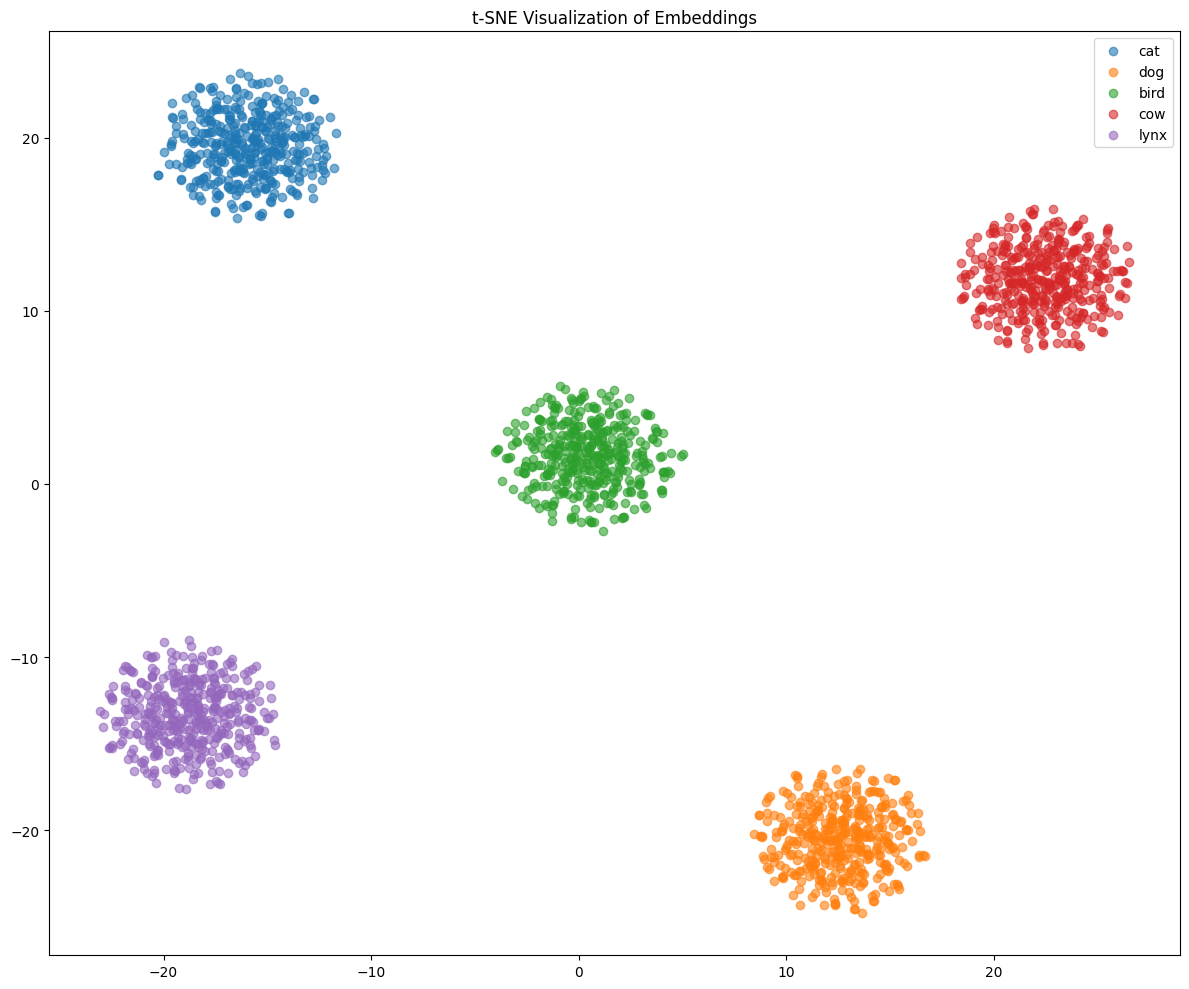

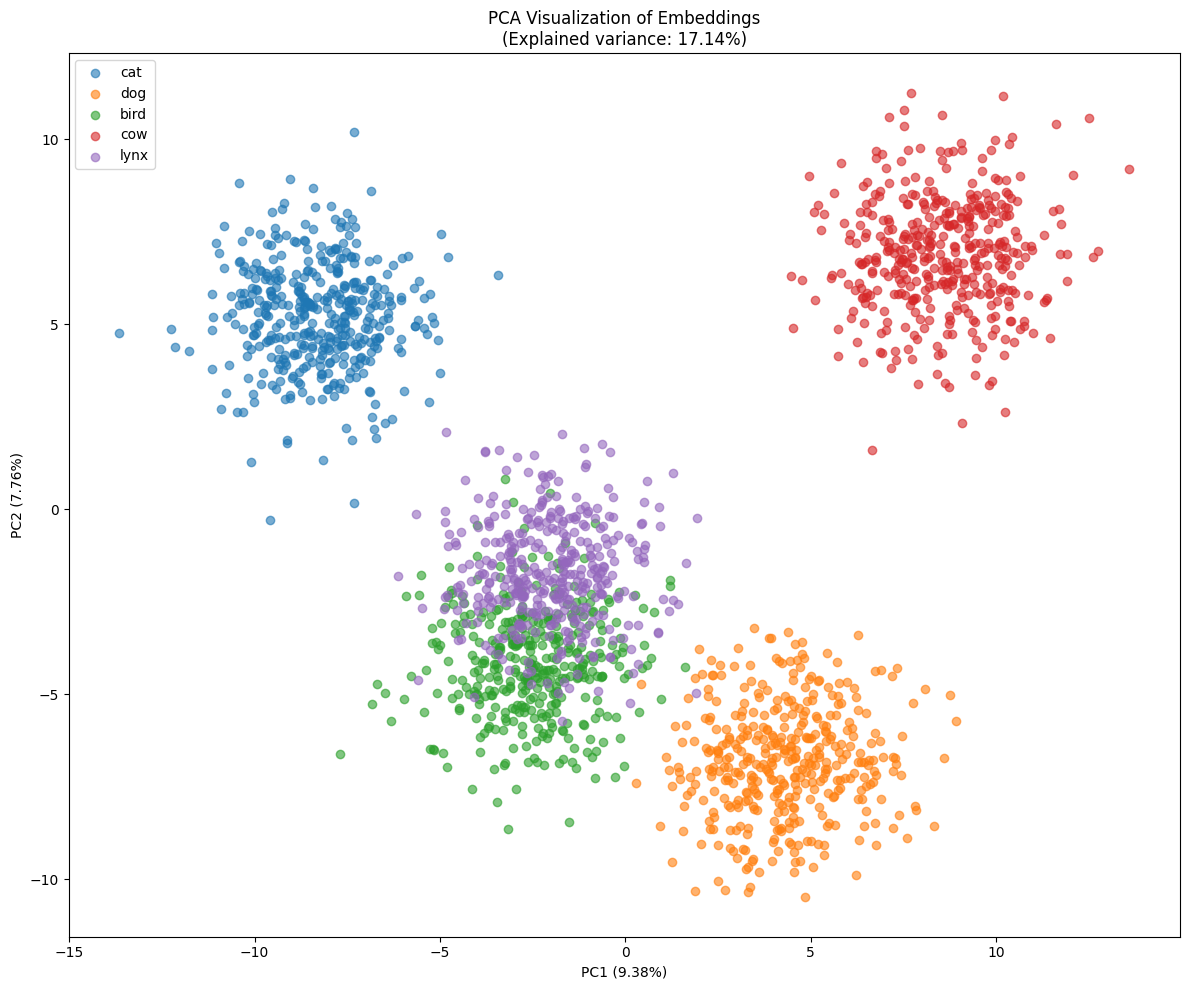

In [6]:
from plotting import visualize_embeddings_tsne, visualize_embeddings_pca

samples_per_class = 500
embedding_dim = 128

# Create clustered embeddings for each class
embeddings = []
labels = []

for class_idx, class_name in enumerate(class_names):
    # Create a cluster center for this class
    center = np.random.normal(0, 1, embedding_dim)
    
    # Generate samples around this center
    class_samples = center + np.random.normal(0, 1.5, (samples_per_class, embedding_dim))
    
    embeddings.append(class_samples)
    labels.append(np.ones(samples_per_class) * class_idx)

# Combine all classes
embeddings = np.vstack(embeddings)
labels = np.hstack(labels)

# Visualize using t-SNE
visualize_embeddings_tsne(
    embeddings=embeddings,
    labels=labels,
    output_dir=None,
    class_names=class_names
)

# Visualize using PCA
visualize_embeddings_pca(
    embeddings=embeddings,
    labels=labels,
    output_dir=None,
    class_names=class_names
)

> Why is the clustering on the same embeddings so different between t-SNE and PCA?

1. **PCA visualization** shows the direction of maximum variance in the data. It tries to preserve the global structure, emphasizing the overall distribution of points. Large distances in the original space remain large in the PCA projection, and the relative positions of distant clusters are generally maintained.

2. **t-SNE visualization** focuses on preserving neighborhood relationships. It excels at revealing local clusters and patterns, making it excellent for visualizing how data points group together. However, the sizes and distances between clusters may not reflect their true relationships in the original space!

**Key Limitations to Be Aware Of**:

- **PCA can miss non-linear structures**: Since PCA is a linear technique, it may fail to capture complex, non-linear relationships in your embeddings. Two classes that are separable by a non-linear boundary might appear mixed in PCA.

- **t-SNE can distort global structure**: While excellent at showing clusters, t-SNE may not preserve the distances between them. Clusters that are far apart in the original space might appear close in t-SNE visualization, or vice versa.

- **t-SNE is sensitive to hyperparameters**: The perplexity parameter in t-SNE (which influences the effective number of neighbors) can significantly affect the visualization. Different perplexity values can produce dramatically different visualizations.

- **Random initialization in t-SNE**: Due to its non-deterministic nature, t-SNE can produce different visualizations in different runs unless you fix the random seed. In `visualize_embeddings_tsne` and `visualize_embeddings_pca` functions, we set the random seed to 42.

**When Interpreting Model Embeddings**:

When examining neural network embeddings, it's important to use both techniques:

- Use **PCA** to understand the global structure and the principal directions of variation
- Use **t-SNE** to identify clusters and local patterns
- Don't draw strong conclusions from a single visualization technique
- Remember that both techniques are simplifications of a complex, high-dimensional space

By understanding the strengths and limitations of each visualization technique, you can better interpret what your neural network has actually learned from the data. A detailed overview about the limitation of each technique can be found ["Understanding Dimensionality Reduction: PCA vs t-SNE vs UMAP vs FIt-SNE vs LargeVis vs Laplacian Eigenmaps"](https://carnotresearch.medium.com/understanding-dimensionality-reduction-pca-vs-t-sne-vs-umap-vs-fit-sne-vs-largevis-vs-laplacian-13d0be9ef7f4) and ["Why you should not rely on t-SNE, UMAP or TriMAP"](https://towardsdatascience.com/why-you-should-not-rely-on-t-sne-umap-or-trimap-f8f5dc333e59/).

In these articles there are also a discussion about other dimension reduction techniques like UMAP (Uniform Manifold Approximation and Projection), TriMAP (Large-scale Dimensionality Reduction Using Triplets), etc. that can be useful for embeddings visualization but won't be covered here.

### 4.4 Using Embeddings in Practice

Besides visualization, embeddings have several practical uses:

1. **Transfer learning**: Use embeddings from pre-trained models as features for new tasks
2. **Similarity search**: Find similar examples by comparing embedding distances
3. **Anomaly detection**: Identify unusual inputs that don't cluster well with known classes
4. **Interpretability**: Analyze which input features influence specific embedding dimensions

### 4.5 Visualizing Patch and Position Embeddings for Vision Transformers

We discuss the concepts of the patch and position embeddings for Vision Transformers in the corresponding notebook.

### 5. One more thing: Finding the right model capacity

Recent research has revealed that the relationship between model capacity and generalization is more complex than the classical U-shaped curve we see in overfitting. When models are scaled significantly beyond the traditional "sweet spot," we observe what's called the "double descent" phenomenon.

<div align="center">
    <img src="figures/double_descent.PNG" width="1000"/>
    <p><i>Figure 3: Double descent risk curve showing improved performance when scaling beyond the interpolation threshold</i></p>
</div>

> What is Double Descent?

The double descent phenomenon ([Belkin et al., 2019](https://www.pnas.org/doi/abs/10.1073/pnas.1903070116)) shows that:

Classical Regime: Initially follows the traditional U-shaped curve with a sweet spot balancing underfitting and overfitting.
Interpolation Threshold: Test error peaks when the model has just enough capacity to perfectly fit the training data.
Modern Interpolating Regime: As model capacity increases further, test error surprisingly decreases again, often below the error at the classical sweet spot.

This explains why extremely large neural networks that perfectly fit training data can still generalize remarkably well in practice.
